==============================\
Student name: Shiqi Yin \
GitHub username: acse-sy121\
\==============================

In [ ]:
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import joblib
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# PCA model
pca_compress = joblib.load('/content/drive/MyDrive/output_files/DATA/PCA_data/pca_compress_to_92.pkl')
# POD coefficients
train_data = joblib.load('/content/drive/MyDrive/output_files/DATA/PCA_data/X_train_pca.pkl')
print(train_data.shape)

(576, 150)


In [ ]:
train_ob_all_values = joblib.load('/content/drive/MyDrive/output_files/DATA/data_used_for_model/train_ob_all_values.pkl')
print(train_ob_all_values.shape)

(576, 126)


In [ ]:
input_timestamps = 9
batchsize = 128
latent_space = 400
step = 1

In [ ]:
scaler_minmax = MinMaxScaler((0,1))
scaler_minmax.fit(train_data)
X_train_array_origin = scaler_minmax.transform(train_data)
X_train_all = np.hstack((X_train_array_origin, train_ob_all_values))

In [ ]:
X_train_all.shape

(576, 276)

In [ ]:
def simplify_dataset(X_train, input_timestamps, step):
  X_train_simp = []
  for i in range(len(X_train) - input_timestamps*step):
    X_train_simp.append(X_train[i:i+input_timestamps*step:step])
  return np.array(X_train_simp) 

In [ ]:
X_train_array = simplify_dataset(X_train_all, input_timestamps, step)
print(X_train_array.shape)

(567, 9, 276)


In [ ]:
def Data_reshape(input_array):
  X_for_conv = (input_array.reshape((input_array.shape[0], input_timestamps, input_array.shape[2], 1))).astype('float32')
  X_output = tf.data.Dataset.from_tensor_slices(X_for_conv)
  X_output = X_output.shuffle(len(X_output))
  X_output = X_output.batch(batchsize)
  print(X_for_conv.shape)
  return X_for_conv, X_output

In [ ]:
X_train_for_conv, X_train = Data_reshape(X_train_array)

(567, 9, 276, 1)


In [ ]:
def make_encoder_model():
  model = keras.Sequential()
  model.add(keras.layers.Conv2D(64, (3, 3), input_shape = [input_timestamps, X_train_all.shape[1], 1], padding='same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())
  model.add(keras.layers.Dropout(0.2))

  model.add(keras.layers.Conv2D(32, (3, 3), padding='same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())
  model.add(keras.layers.Dropout(0.2))

  model.add(keras.layers.Conv2D(16, (3, 3), padding='same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())
  model.add(keras.layers.Dropout(0.2))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(latent_space))

  return model

def make_decoder_model():
  model = keras.Sequential()
  model.add(keras.layers.Dense(X_train_for_conv.shape[1]*X_train_for_conv.shape[2]*16, use_bias=False, activation = 'relu', input_shape = (latent_space,)))
  model.add(keras.layers.Reshape((input_timestamps, X_train_all.shape[1], 16)))

  model.add(keras.layers.Conv2DTranspose(32, (3, 3), padding = 'same', use_bias=False))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())

  model.add(keras.layers.Conv2DTranspose(64, (3, 3), padding = 'same', use_bias=False))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())

  model.add(keras.layers.Conv2DTranspose(1, (3, 3), padding = 'same', output_padding=[0,0], use_bias=False, activation='sigmoid'))

  return model

In [ ]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(keras.layers.Dense(768, activation="relu", input_shape=(latent_space,)))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(384, activation="relu"))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(128, activation="relu"))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(1))

  return model

In [ ]:
encoder = make_encoder_model()
encoder.summary()
decoder = make_decoder_model()
decoder.summary()
discriminator = make_discriminator_model()
discriminator.summary()
autoencoder = keras.Sequential([encoder, decoder])
# autoencoder.summary()
encoder_disc = keras.Sequential([encoder, discriminator])
# encoder_disc.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 9, 276, 64)        640       
                                                                 
 batch_normalization_15 (Bat  (None, 9, 276, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 9, 276, 64)        0         
                                                                 
 dropout_18 (Dropout)        (None, 9, 276, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 9, 276, 32)        18464     
                                                                 
 batch_normalization_16 (Bat  (None, 9, 276, 32)       128       
 chNormalization)                                    

In [ ]:
# After grid search, Adam is choosen because it performs the best

a_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)  

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()
@tf.function
def compute_autoencoder_loss(x, x_logit):
    """
    Calculate mean square error 
    between the input of the encoder 
    and the output of the decoder 
    
    Parameters
    ----------
    x : Tensor 
      the input of the encoder
    x_logit : Tensor
      the output of the decoder

    Returns
    -------
    Tensor
      mean squared loss between x and x_logit
    """  
    autoencoder_loss = mse(x, x_logit)
    return autoencoder_loss

@tf.function
def compute_discriminator_loss(fake_output, real_output):
    """
    Calculate cross entropy loss 
    between random noise and one, 
    the output of the encoder and zero 
    
    Parameters
    ----------
    fake_output : Tensor 
      the result of the discriminator 
      on the output of the encoder 
    real_output : Tensor
      the result of the discriminator 
      on the output of random noise
      
    Returns
    -------
    Tensor
      the discrimination result
      on the output of the encoder and random noise
    """  
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

@tf.function
def compute_decoder_loss(fake_output):
    """
    Calculate cross entropy loss 
    between the output of the encoder and one 
    
    Parameters
    ----------
    fake_output : Tensor 
      the result of the discriminator 
      on the output of the encoder 
      
    Returns
    -------
    Tensor
      the cross entropy loss
      between the output of the encoder and one 
    """    
    return cross_entropy(tf.ones_like(fake_output), fake_output)

autoencoder_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
decoder_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
discriminator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

In [ ]:
@tf.function
def train_step(batch):
    # Autoencoder update
    with tf.GradientTape() as ae_tape:
        encoder_output = encoder(batch, training=True)
        decoder_output = decoder(encoder_output, training=True)
        autoencoder_loss = compute_autoencoder_loss(batch, decoder_output)

    a_gradients = ae_tape.gradient(autoencoder_loss, encoder.trainable_variables + decoder.trainable_variables)
    a_optimizer.apply_gradients(zip(a_gradients, encoder.trainable_variables + decoder.trainable_variables))

    # Discriminator update
    with tf.GradientTape() as d_tape:
        z = encoder(batch, training=True)
        true_z = tf.random.normal(shape=(z.shape))
        fake_output = discriminator(z, training=True)
        true_output = discriminator(true_z, training=True)
        discriminator_loss = compute_discriminator_loss(fake_output, true_output)
    d_gradients = d_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

    # Decoder update
    with tf.GradientTape() as g_tape:
        z = encoder(batch, training=True)
        fake_output = discriminator(z, training=True)
        decoder_loss = compute_decoder_loss(fake_output)
    g_gradients = g_tape.gradient(decoder_loss, encoder.trainable_variables)
    g_optimizer.apply_gradients(zip(g_gradients, encoder.trainable_variables))

    autoencoder_mean_loss(autoencoder_loss)
    decoder_mean_loss(decoder_loss)
    discriminator_mean_loss(discriminator_loss)

In [ ]:
def train(dataset, epochs):
    hist = []
    aeloss = []
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch + 1, epochs))   
        for batch in dataset:
          train_step(batch)

        hist.append([decoder_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])
        aeloss.append(autoencoder_mean_loss.result().numpy())

        # Resets metric state variables.
        decoder_mean_loss.reset_states()
        discriminator_mean_loss.reset_states()
        autoencoder_mean_loss.reset_states()

        print("encoder loss: ", hist[-1][0]," - ", "discriminator loss: ", hist[-1][1])
        print("autoencoder loss: ", aeloss[-1])
        
        if epoch > 0 and (epoch+1)%1000 == 0:
            # Plot loss
            print('Loss: ')
            fig, ax = plt.subplots(1,1, figsize=[20,10])
            ax.plot(hist)
            ax.legend(['loss_enc', 'loss_disc'])
            ax.grid()
            plt.show()
         
    return hist, aeloss

Epoch 1/10000
encoder loss:  0.17228363  -  discriminator loss:  7.485736
autoencoder loss:  0.05920122
Epoch 2/10000
encoder loss:  0.006391281  -  discriminator loss:  11.9332075
autoencoder loss:  0.027631868
Epoch 3/10000
encoder loss:  0.13782938  -  discriminator loss:  9.51808
autoencoder loss:  0.021790318
Epoch 4/10000
encoder loss:  0.11441685  -  discriminator loss:  9.739006
autoencoder loss:  0.019217346
Epoch 5/10000
encoder loss:  0.1914808  -  discriminator loss:  8.362093
autoencoder loss:  0.017845428
Epoch 6/10000
encoder loss:  0.41832566  -  discriminator loss:  7.4608297
autoencoder loss:  0.016939085
Epoch 7/10000
encoder loss:  0.36235908  -  discriminator loss:  7.3253875
autoencoder loss:  0.016673386
Epoch 8/10000
encoder loss:  0.59444416  -  discriminator loss:  6.5387373
autoencoder loss:  0.016562507
Epoch 9/10000
encoder loss:  0.7014729  -  discriminator loss:  6.269218
autoencoder loss:  0.016307332
Epoch 10/10000
encoder loss:  0.88315856  -  discrimi

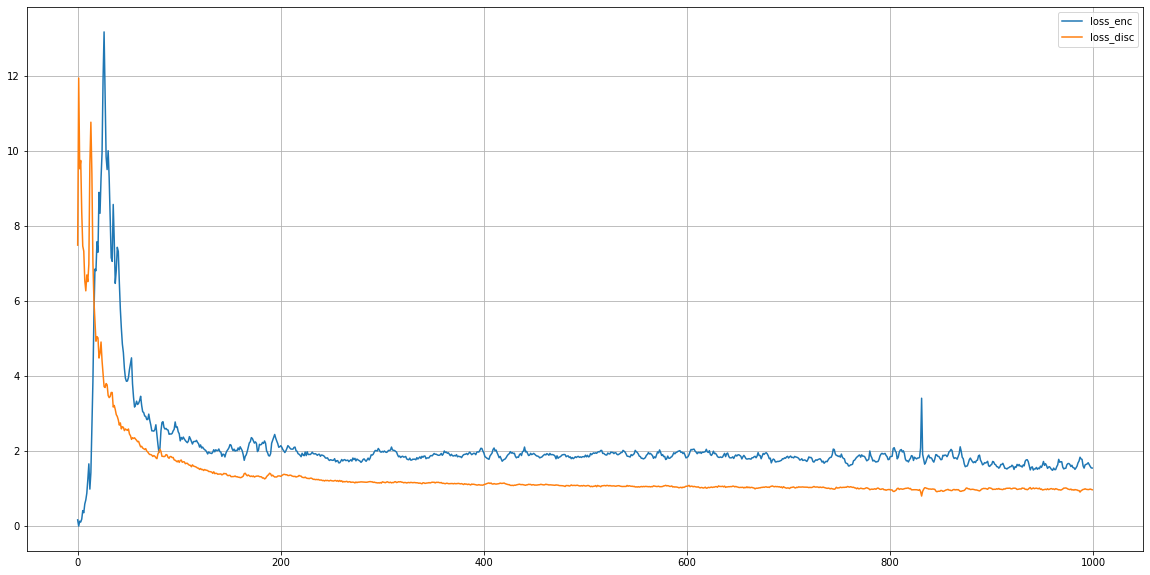

Epoch 1001/10000
encoder loss:  1.5820775  -  discriminator loss:  0.9826247
autoencoder loss:  0.0016937449
Epoch 1002/10000
encoder loss:  1.6342806  -  discriminator loss:  0.9743948
autoencoder loss:  0.0016718699
Epoch 1003/10000
encoder loss:  1.6705652  -  discriminator loss:  0.94804347
autoencoder loss:  0.0017148536
Epoch 1004/10000
encoder loss:  1.629668  -  discriminator loss:  0.9297469
autoencoder loss:  0.0016473888
Epoch 1005/10000
encoder loss:  1.734181  -  discriminator loss:  0.9276226
autoencoder loss:  0.0017549281
Epoch 1006/10000
encoder loss:  1.7861532  -  discriminator loss:  0.9031228
autoencoder loss:  0.0017156064
Epoch 1007/10000
encoder loss:  1.7764807  -  discriminator loss:  0.9048799
autoencoder loss:  0.0017384791
Epoch 1008/10000
encoder loss:  1.804321  -  discriminator loss:  0.91096973
autoencoder loss:  0.0018157918
Epoch 1009/10000
encoder loss:  1.728583  -  discriminator loss:  0.93052375
autoencoder loss:  0.0018892672
Epoch 1010/10000
enc

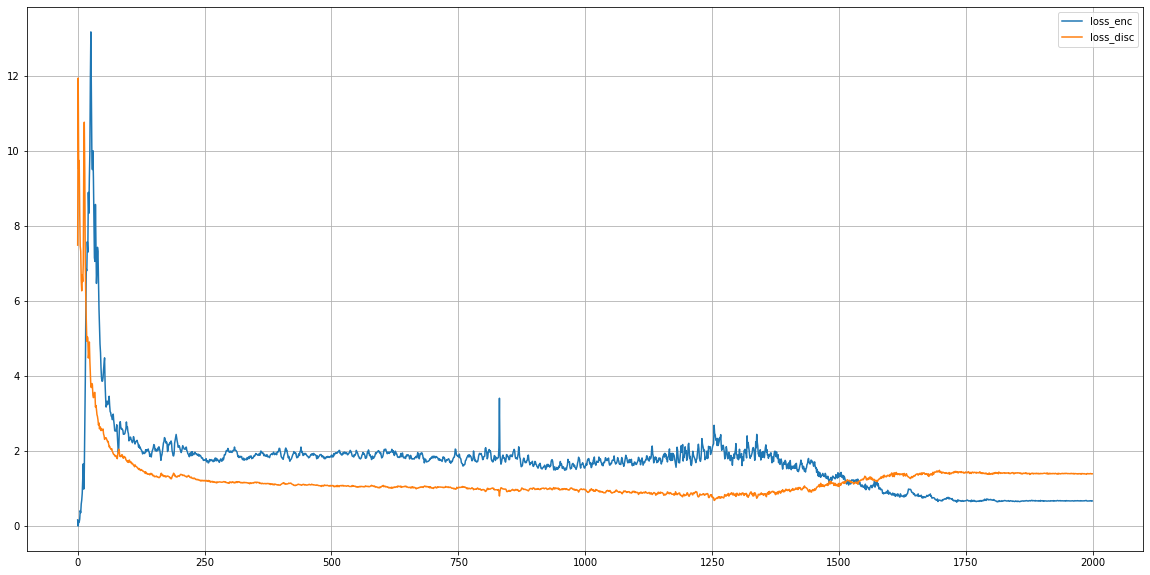

Epoch 2001/10000
encoder loss:  0.67312986  -  discriminator loss:  1.4057696
autoencoder loss:  0.0003239845
Epoch 2002/10000
encoder loss:  0.68296707  -  discriminator loss:  1.3852475
autoencoder loss:  0.00032340566
Epoch 2003/10000
encoder loss:  0.67994696  -  discriminator loss:  1.397261
autoencoder loss:  0.0003418726
Epoch 2004/10000
encoder loss:  0.67808527  -  discriminator loss:  1.4023429
autoencoder loss:  0.00034029884
Epoch 2005/10000
encoder loss:  0.68586046  -  discriminator loss:  1.3977268
autoencoder loss:  0.00033564985
Epoch 2006/10000
encoder loss:  0.6825477  -  discriminator loss:  1.3981451
autoencoder loss:  0.00032792782
Epoch 2007/10000
encoder loss:  0.67741454  -  discriminator loss:  1.3918625
autoencoder loss:  0.00034490466
Epoch 2008/10000
encoder loss:  0.67740446  -  discriminator loss:  1.3971946
autoencoder loss:  0.00032046024
Epoch 2009/10000
encoder loss:  0.68105173  -  discriminator loss:  1.3926903
autoencoder loss:  0.00031857117
Epoch

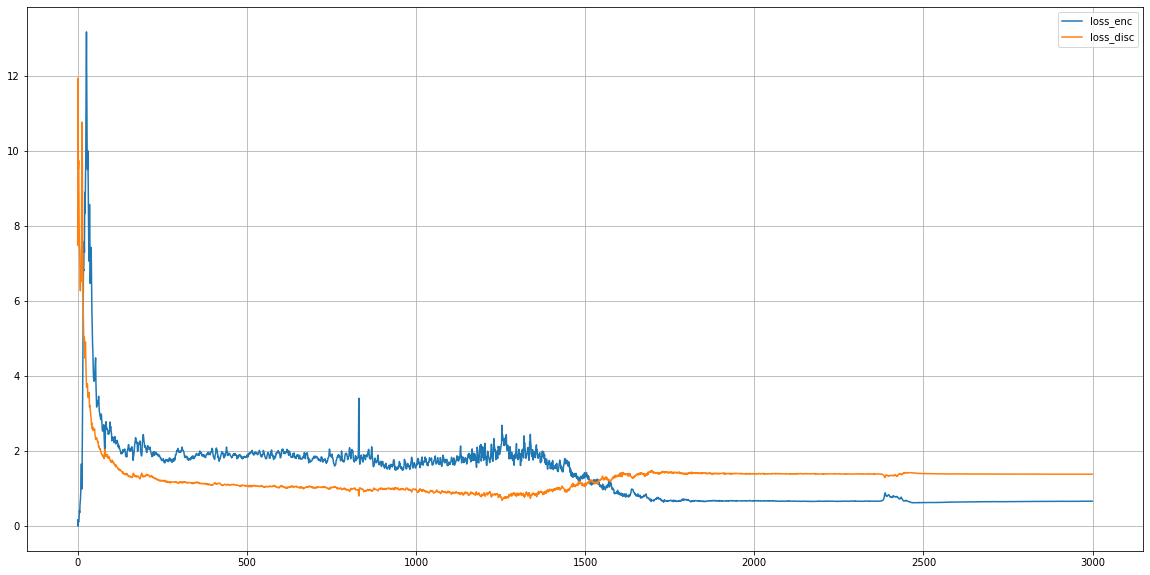

Epoch 3001/10000
encoder loss:  0.6684512  -  discriminator loss:  1.3871609
autoencoder loss:  0.0001433444
Epoch 3002/10000
encoder loss:  0.6677992  -  discriminator loss:  1.3879759
autoencoder loss:  0.00013631233
Epoch 3003/10000
encoder loss:  0.66912514  -  discriminator loss:  1.3878601
autoencoder loss:  0.00013893648
Epoch 3004/10000
encoder loss:  0.6697438  -  discriminator loss:  1.3893464
autoencoder loss:  0.00013578871
Epoch 3005/10000
encoder loss:  0.66808295  -  discriminator loss:  1.3895888
autoencoder loss:  0.00013378919
Epoch 3006/10000
encoder loss:  0.6699123  -  discriminator loss:  1.3895519
autoencoder loss:  0.00013110906
Epoch 3007/10000
encoder loss:  0.6679471  -  discriminator loss:  1.3887192
autoencoder loss:  0.00013142629
Epoch 3008/10000
encoder loss:  0.6695274  -  discriminator loss:  1.3894506
autoencoder loss:  0.00013537602
Epoch 3009/10000
encoder loss:  0.66861093  -  discriminator loss:  1.3888439
autoencoder loss:  0.00013304732
Epoch 30

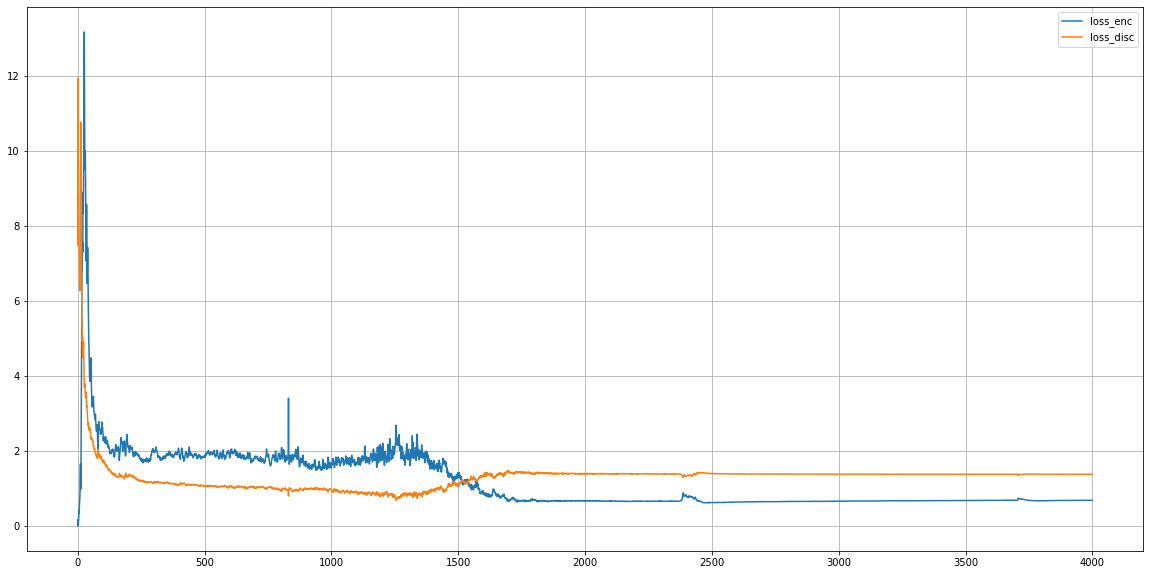

Epoch 4001/10000
encoder loss:  0.6923691  -  discriminator loss:  1.3869442
autoencoder loss:  0.00010489397
Epoch 4002/10000
encoder loss:  0.69237214  -  discriminator loss:  1.386342
autoencoder loss:  9.391861e-05
Epoch 4003/10000
encoder loss:  0.6919256  -  discriminator loss:  1.386977
autoencoder loss:  0.000102062375
Epoch 4004/10000
encoder loss:  0.69184023  -  discriminator loss:  1.3868284
autoencoder loss:  9.638276e-05
Epoch 4005/10000
encoder loss:  0.6919456  -  discriminator loss:  1.3859336
autoencoder loss:  9.349346e-05
Epoch 4006/10000
encoder loss:  0.6921267  -  discriminator loss:  1.3860375
autoencoder loss:  9.221902e-05
Epoch 4007/10000
encoder loss:  0.69208986  -  discriminator loss:  1.3862413
autoencoder loss:  9.2822665e-05
Epoch 4008/10000
encoder loss:  0.69200003  -  discriminator loss:  1.3871777
autoencoder loss:  9.548646e-05
Epoch 4009/10000
encoder loss:  0.6921174  -  discriminator loss:  1.38572
autoencoder loss:  0.00010024593
Epoch 4010/100

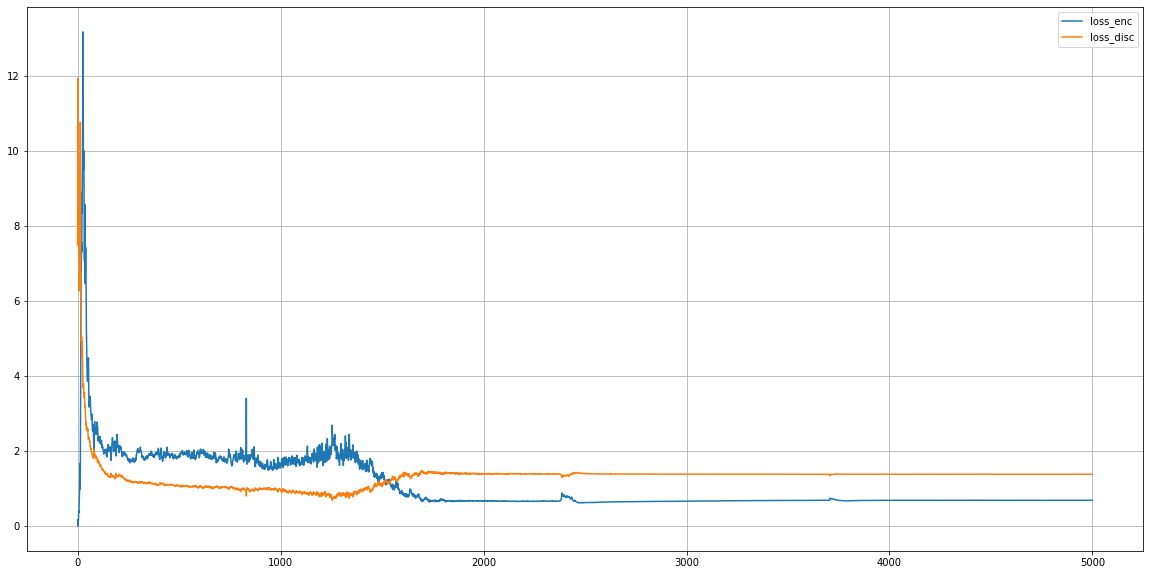

Epoch 5001/10000
encoder loss:  0.69327384  -  discriminator loss:  1.3863704
autoencoder loss:  9.408054e-05
Epoch 5002/10000
encoder loss:  0.6933506  -  discriminator loss:  1.3860766
autoencoder loss:  9.597826e-05
Epoch 5003/10000
encoder loss:  0.6933845  -  discriminator loss:  1.3863027
autoencoder loss:  9.501231e-05
Epoch 5004/10000
encoder loss:  0.6932952  -  discriminator loss:  1.386299
autoencoder loss:  8.563624e-05
Epoch 5005/10000
encoder loss:  0.6931201  -  discriminator loss:  1.3864183
autoencoder loss:  8.182427e-05
Epoch 5006/10000
encoder loss:  0.69363326  -  discriminator loss:  1.3863418
autoencoder loss:  8.3768726e-05
Epoch 5007/10000
encoder loss:  0.6935366  -  discriminator loss:  1.3856865
autoencoder loss:  8.182182e-05
Epoch 5008/10000
encoder loss:  0.69350845  -  discriminator loss:  1.3859125
autoencoder loss:  8.099944e-05
Epoch 5009/10000
encoder loss:  0.69353473  -  discriminator loss:  1.3865926
autoencoder loss:  8.143912e-05
Epoch 5010/1000

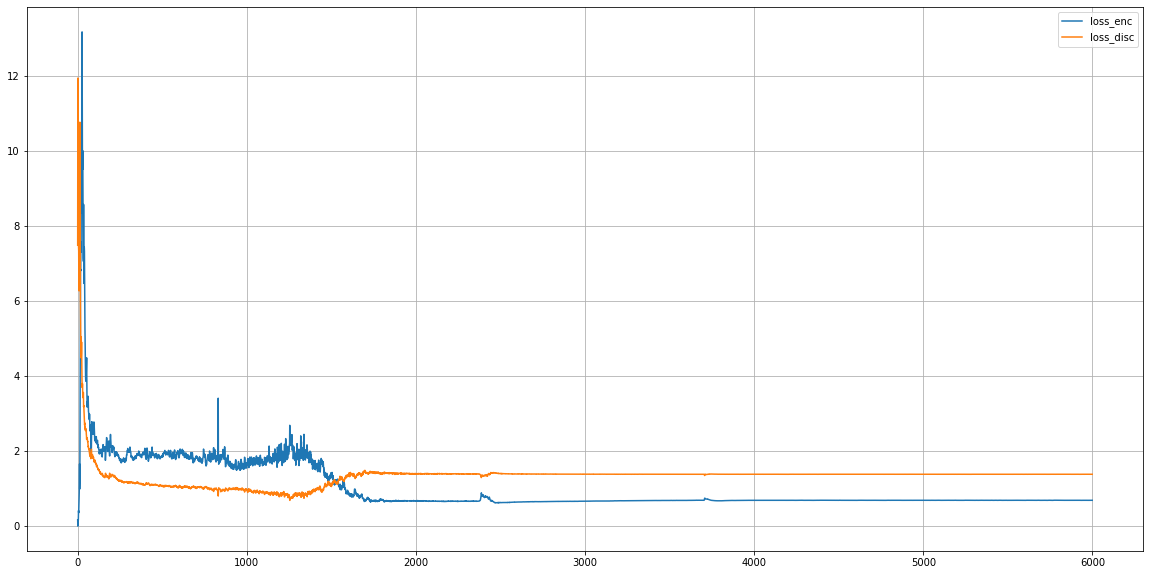

Epoch 6001/10000
encoder loss:  0.6930007  -  discriminator loss:  1.3862476
autoencoder loss:  9.987636e-05
Epoch 6002/10000
encoder loss:  0.6928712  -  discriminator loss:  1.386267
autoencoder loss:  9.385261e-05
Epoch 6003/10000
encoder loss:  0.6929996  -  discriminator loss:  1.3862455
autoencoder loss:  8.8894456e-05
Epoch 6004/10000
encoder loss:  0.69272476  -  discriminator loss:  1.3858078
autoencoder loss:  8.9577035e-05
Epoch 6005/10000
encoder loss:  0.6929557  -  discriminator loss:  1.38652
autoencoder loss:  8.530753e-05
Epoch 6006/10000
encoder loss:  0.69330865  -  discriminator loss:  1.3863308
autoencoder loss:  8.6468164e-05
Epoch 6007/10000
encoder loss:  0.6927377  -  discriminator loss:  1.3862132
autoencoder loss:  8.016012e-05
Epoch 6008/10000
encoder loss:  0.69269586  -  discriminator loss:  1.3859818
autoencoder loss:  8.7103166e-05
Epoch 6009/10000
encoder loss:  0.692912  -  discriminator loss:  1.3859895
autoencoder loss:  8.4489366e-05
Epoch 6010/1000

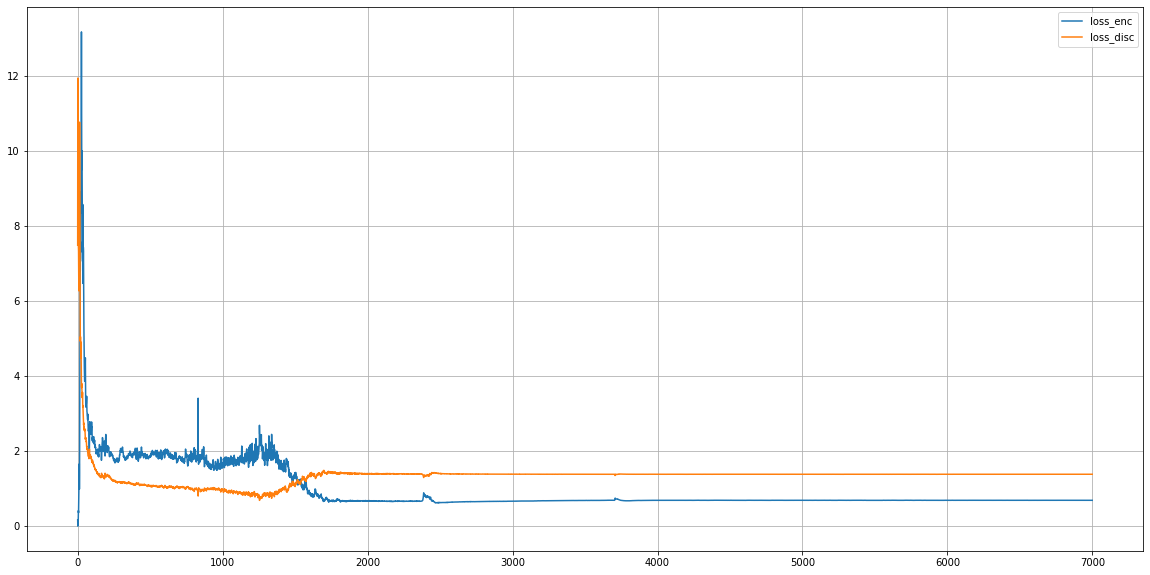

Epoch 7001/10000
encoder loss:  0.6928259  -  discriminator loss:  1.3862063
autoencoder loss:  7.353157e-05
Epoch 7002/10000
encoder loss:  0.692808  -  discriminator loss:  1.3861705
autoencoder loss:  7.2046445e-05
Epoch 7003/10000
encoder loss:  0.6930104  -  discriminator loss:  1.3865026
autoencoder loss:  7.555682e-05
Epoch 7004/10000
encoder loss:  0.693155  -  discriminator loss:  1.3860724
autoencoder loss:  7.8486264e-05
Epoch 7005/10000
encoder loss:  0.6931137  -  discriminator loss:  1.3863748
autoencoder loss:  7.936983e-05
Epoch 7006/10000
encoder loss:  0.69290894  -  discriminator loss:  1.3862407
autoencoder loss:  7.984277e-05
Epoch 7007/10000
encoder loss:  0.6930732  -  discriminator loss:  1.3864658
autoencoder loss:  7.841156e-05
Epoch 7008/10000
encoder loss:  0.6930771  -  discriminator loss:  1.3861692
autoencoder loss:  8.0751444e-05
Epoch 7009/10000
encoder loss:  0.6931039  -  discriminator loss:  1.3862735
autoencoder loss:  7.2651135e-05
Epoch 7010/10000

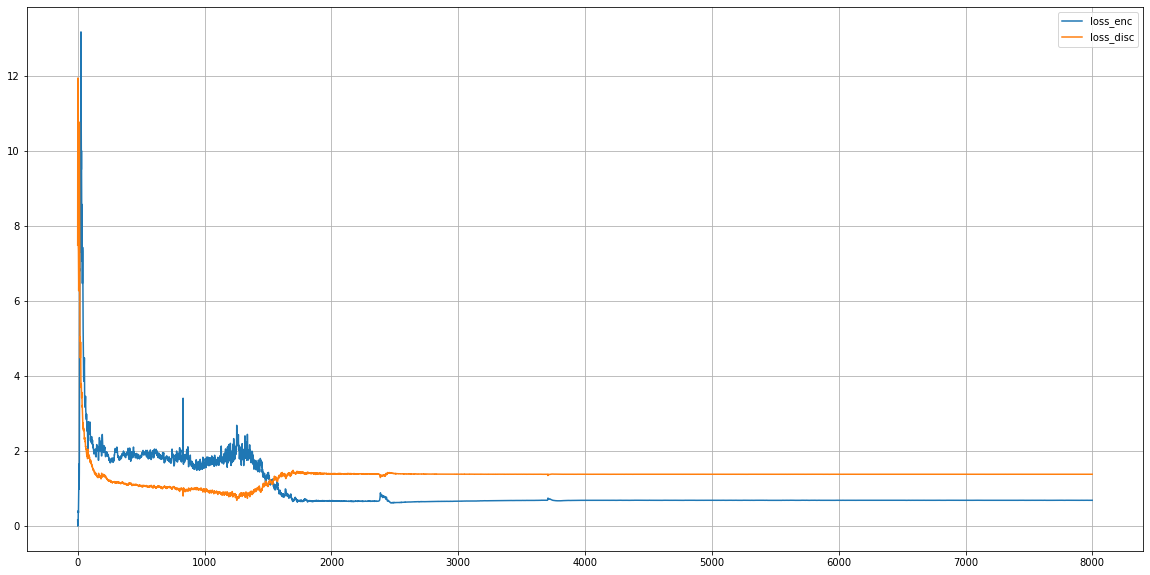

Epoch 8001/10000
encoder loss:  0.69280857  -  discriminator loss:  1.3861815
autoencoder loss:  6.0886225e-05
Epoch 8002/10000
encoder loss:  0.69298446  -  discriminator loss:  1.3862178
autoencoder loss:  5.907023e-05
Epoch 8003/10000
encoder loss:  0.69286364  -  discriminator loss:  1.3865874
autoencoder loss:  6.010157e-05
Epoch 8004/10000
encoder loss:  0.69296676  -  discriminator loss:  1.3864466
autoencoder loss:  6.3336265e-05
Epoch 8005/10000
encoder loss:  0.6928283  -  discriminator loss:  1.386329
autoencoder loss:  6.0809078e-05
Epoch 8006/10000
encoder loss:  0.69277656  -  discriminator loss:  1.3863662
autoencoder loss:  5.9366015e-05
Epoch 8007/10000
encoder loss:  0.69264877  -  discriminator loss:  1.3862104
autoencoder loss:  5.7927427e-05
Epoch 8008/10000
encoder loss:  0.6927899  -  discriminator loss:  1.3863083
autoencoder loss:  5.7652283e-05
Epoch 8009/10000
encoder loss:  0.69284993  -  discriminator loss:  1.386142
autoencoder loss:  6.142892e-05
Epoch 80

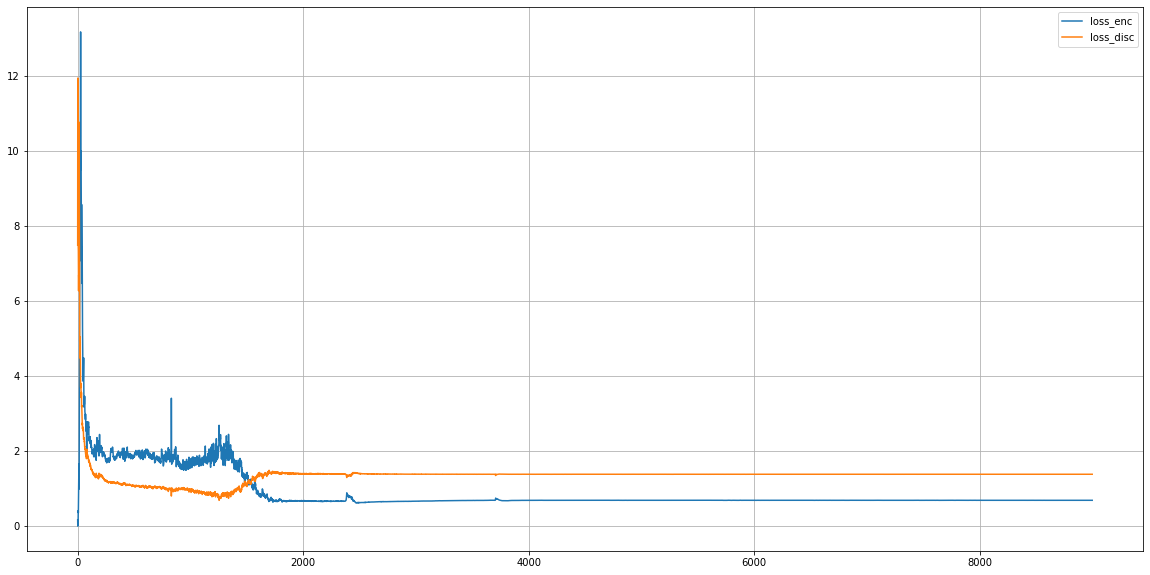

Epoch 9001/10000
encoder loss:  0.69324446  -  discriminator loss:  1.3862562
autoencoder loss:  5.358243e-05
Epoch 9002/10000
encoder loss:  0.6932062  -  discriminator loss:  1.3861281
autoencoder loss:  5.457782e-05
Epoch 9003/10000
encoder loss:  0.69310826  -  discriminator loss:  1.3863778
autoencoder loss:  5.2967887e-05
Epoch 9004/10000
encoder loss:  0.69308776  -  discriminator loss:  1.3861306
autoencoder loss:  5.2441057e-05
Epoch 9005/10000
encoder loss:  0.6930899  -  discriminator loss:  1.3862736
autoencoder loss:  5.1901116e-05
Epoch 9006/10000
encoder loss:  0.6931266  -  discriminator loss:  1.3863765
autoencoder loss:  5.8029684e-05
Epoch 9007/10000
encoder loss:  0.6930712  -  discriminator loss:  1.3863809
autoencoder loss:  5.2131305e-05
Epoch 9008/10000
encoder loss:  0.6929038  -  discriminator loss:  1.3864435
autoencoder loss:  5.1711133e-05
Epoch 9009/10000
encoder loss:  0.69298905  -  discriminator loss:  1.3863518
autoencoder loss:  5.356936e-05
Epoch 901

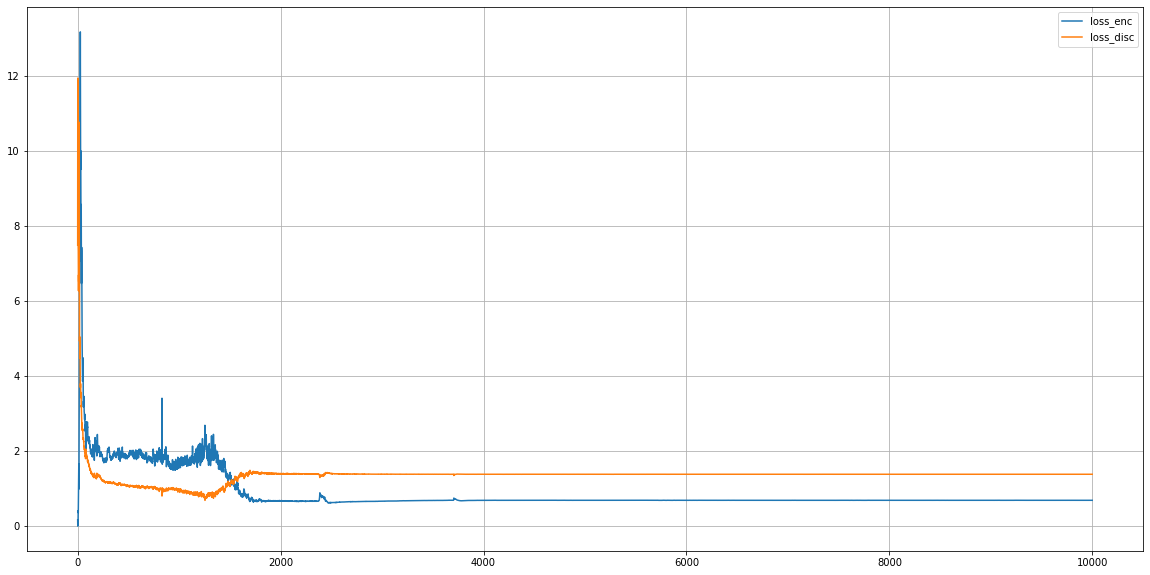

In [ ]:
hist, autoencoder_loss = train(X_train, epochs=10000)

In [ ]:
a = copy.deepcopy(hist)
losses = copy.deepcopy(hist)
a = np.array(a)
print(a.shape)
print(autoencoder_loss[0])
for i in range(len(hist)):
  losses[i].append(autoencoder_loss[i])

losses_arr = np.array(losses)
losses_arr.shape

(10000, 2)
0.05920122


(10000, 3)

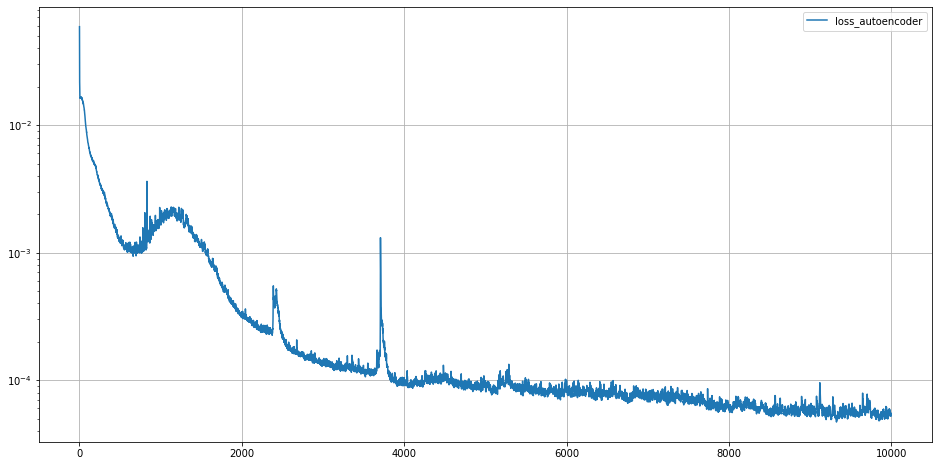

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[16,8])
ax.plot(autoencoder_loss)
ax.legend(['loss_autoencoder'])
ax.set_yscale('log')
ax.grid()
plt.savefig("/content/drive/MyDrive/output_files/Figures/Figures_with_DA/Training/autoencoder_loss3.png")

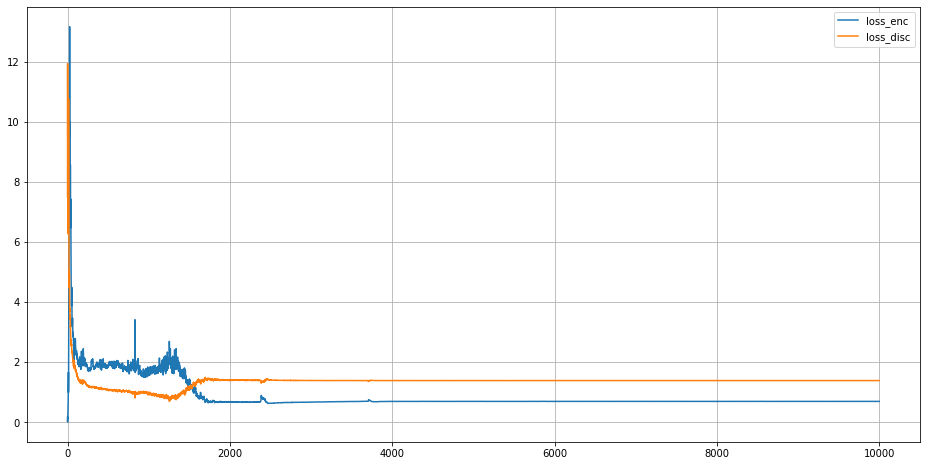

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[16,8])
ax.plot(hist)
ax.legend(['loss_enc', 'loss_disc'])
ax.grid()
plt.savefig("/content/drive/MyDrive/output_files/Figures/Figures_with_DA/Training/enc_disc_loss3.png")

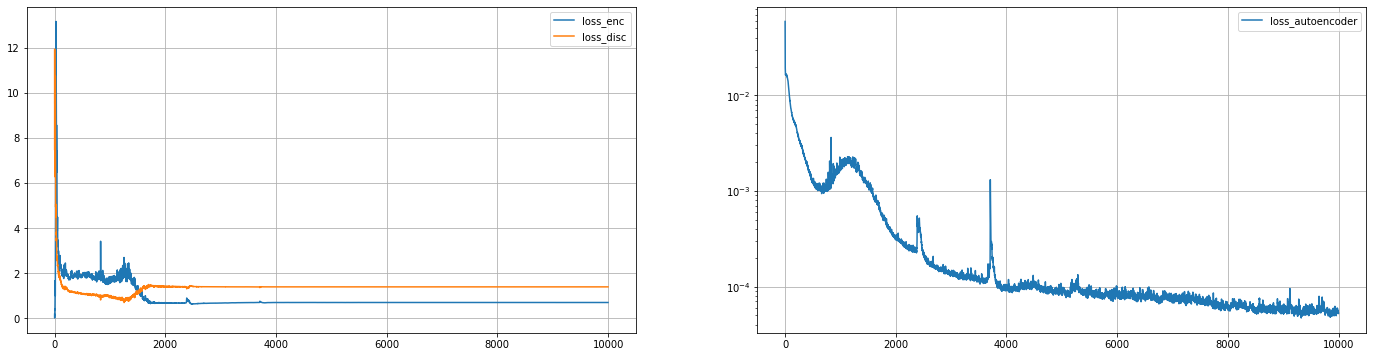

In [ ]:
fig, ax = plt.subplots(1,2, figsize=[24,6])
ax[0].plot(hist)
ax[0].legend(['loss_enc', 'loss_disc'])
ax[0].grid()
ax[1].plot(autoencoder_loss)
ax[1].legend(['loss_autoencoder'])
ax[1].set_yscale('log')
ax[1].grid()

plt.savefig("/content/drive/MyDrive/output_files/Figures/Figures_with_DA/Training/losses10000.png")

In [ ]:
joblib.dump(scaler_minmax, '/content/drive/MyDrive/output_files/scalers/node_data/scaler_with_DA/scaler_minmax01.pkl')
autoencoder.save('/content/drive/MyDrive/output_files/Models/with_sensor/autoencoder_10000.h5')
encoder_disc.save('/content/drive/MyDrive/output_files/Models/with_sensor/encoder_disc_10000.h5')